# Notebook 2.2: Exploratory data analysis - Dimension Reduction

## TOC:
* [Data Preparation](#data_preparation)
    * [Positive data](#positive_data)
        * [Step 1: Obtain necessary data from chart dataset](#positive_step_1)
        * [Step 2: Obtain lyrics from lyrics dataset](#positive_step_2)
    * [Negative data](#negative_data)
        * [Step 1: Randonly sample from lyrics dataset](#negative_step_1)
        * [Step 2: Get song url with spotify API](#negative_step_2)
    * [Get features for both positive and negative samples](#get_features_all)
        * [Step 1: Declare necessary functions](#declare_necessary)
        * [Step 2: Get features for positive samples](#get_positive_features)
        * [Step 3: Get features for negative samples](#get_negative_features)
    * [Merging positive and negative samples](#merge_all)
        * [Step 1: Tag positive and negative samples](#merge_step_1)
        * [Step 2: Merge together](#merge_step_2)
    * [Further processing of data](#further_processing)


### Import necessary library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px

C:\Users\tiany\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tiany\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\tiany\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from gensim.models.doc2vec import Doc2Vec as GenSimDoc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from sentence_transformers import SentenceTransformer


# Dimension reduction

### Dimensionality reduction technique 
Dimensionality reduction technique such as principle components alaysis (PCA), t-distributed Stochastic Neighbor Embedding (t-SNE) are communly used to reduce the dimension of features while preserving the important information (pairwise similarities between data points). This could be useful for visualizing complex datasets with non-linear relationship. 

Unlike other dimensionality reduction techniques like PCA or LSA, t-SNE is particularly useful for visualizing complex datasets with **non-linear relationships**, which aligns with our dataset, in which we could not be able to locate significant inter-feature linear relationship.

Hence, we choose to use **t-SNE** as our primary dimension reduction method. 

**Lyrics**, as a type of **text data**, can be represented as **high-dimensional and sparse feature vectors** after undergoing different feature extraction methods such as tf-idf, doc2vec, sbert, etc. In order to discover the relationship of lyrics and popularity, we perform different feature extraction method on lyrics, perform t-SNE, and visualise the result.

We will perform dimension reduction on both:
1. features
2. lyrics

and try to find their relationship with popularity. 

### Davies-Bouldin score (dbs)
In order to better measure the relationship between features and popularity, we will introduce the metric Davies-Bouldin score.

Davies-Bouldin score is a clustering evaluation metric used to **determine the quality of clustering results**. It is calculated by comparing the distance between clusters and the size of clusters, and is based on the idea that clusters with smaller intra-cluster distance and larger inter-cluster distance are more optimal. 

A **lower Davies-Bouldin score** indicates that data points are **more clustered**, with 0 being the ideal value.



## t-SNE
we will first declare necessary function for t-SNE

In [3]:
tsne =  TSNE(n_components=2, random_state=42, init = 'random')
tsne_3d =  TSNE(n_components=3, random_state=42, init = 'random')
result = []


In [4]:
def dimension(x, label, name, s=10):
    X = tsne.fit_transform(x)
    dbs =  davies_bouldin_score(X, label)
    result.append([dbs, name])
    print(f'dbs: {dbs}')
    fig, ax = plt.subplots(figsize = (20,20))
    sb.scatterplot(x = X[:,0], y = X[:, 1], hue = label, s = s)


In [5]:
def dimension3d (embedding_name, label):
    X = tsne_3d.fit_transform(x)
    dbs =  davies_bouldin_score(X, label)
    print(f'dbs: {dbs}')
    fig = px.scatter_3d(x = X[:,0], y = X[:, 1], z = X[:, 2], color = label)
    fig.show()

## t-SNE on features
### Read positive and negative data

In [6]:
df_all = pd.read_csv("positive_and_negative.csv")
df_all.head()

,tag,artist,year,views,features,lyrics,id,url,acousticness,danceability,...,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,url_clean,if_popular
0,pop,AKING,2015,0.000044,{},Glorious mistakes are anxiously waiting to be ...,985583,https://open.spotify.com/track/30sr35axWFPOvmi...,0.760040,0.806517,...,4,0.359676,0.739733,1,0.049686,0.540682,0.570552,0.314607,30sr35axWFPOvmijSfEfdM,False
1,rap,Filip Winther,2020,0.000001,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257,https://open.spotify.com/track/4mznGf6tTvHp74y...,0.020681,0.894094,...,11,0.100000,0.789644,0,0.399371,0.693969,0.501022,0.000000,4mznGf6tTvHp74y0oPOgoD,False
2,pop,Dan Reeder,2018,0.000015,{},The guy who bathes in the pond at the park\nTh...,3407076,https://open.spotify.com/track/1UbSSyqIVEkooKe...,0.993976,0.554990,...,5,0.113475,0.579224,1,0.039099,0.570105,0.640082,0.213483,1UbSSyqIVEkooKeJTz8IgX,False
3,pop,Noa Azazel,2021,0.000001,{},[Pre-Chorus]\nWhen the moon is taking over i'm...,7061926,https://open.spotify.com/track/51F8whLH1Qou7iV...,0.214858,0.419552,...,1,0.113475,0.682223,0,0.061635,0.639886,0.179959,0.011236,51F8whLH1Qou7iVctzkaPF,False
4,rap,070 Phi,2019,0.000020,{},[Chorus]\nAin't no way that you ain't eatin' w...,4241387,https://open.spotify.com/track/0mvzUwvyLT1Dm1y...,0.367469,0.695519,...,0,0.142857,0.771183,0,0.299790,0.376136,0.712679,0.112360,0mvzUwvyLT1Dm1y2L5tniv,False


In [7]:
y_popular = df_all['if_popular']

### obtain features

In [8]:
feature_all = df_all[df_all.columns[8:21]]
feature_all

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity
0,0.760040,0.806517,0.144170,0.529834,0.000373,4,0.359676,0.739733,1,0.049686,0.540682,0.570552,0.314607
1,0.020681,0.894094,0.141797,0.696247,0.000000,11,0.100000,0.789644,0,0.399371,0.693969,0.501022,0.000000
2,0.993976,0.554990,0.044422,0.088640,0.207661,5,0.113475,0.579224,1,0.039099,0.570105,0.640082,0.213483
3,0.214858,0.419552,0.169140,0.340364,0.000000,1,0.113475,0.682223,0,0.061635,0.639886,0.179959,0.011236
4,0.367469,0.695519,0.146753,0.631085,0.000000,0,0.142857,0.771183,0,0.299790,0.376136,0.712679,0.112360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9529,0.360441,0.821792,0.161581,0.773438,0.002188,5,0.306991,0.826203,0,0.291405,0.646297,0.886503,0.640449
9530,0.000092,0.542770,0.154411,0.932833,0.000793,8,0.100405,0.817852,1,0.076730,0.674827,0.553170,0.191011
9531,0.137549,0.719959,0.142190,0.833587,0.000000,3,0.116515,0.920379,1,0.054193,0.508760,0.805726,0.764045
9532,0.146585,0.626273,0.122640,0.520812,0.778226,2,0.111449,0.770324,1,0.033333,0.531659,0.046012,0.876404


### Perform dimension reduction

dbs: 33.71364263165044


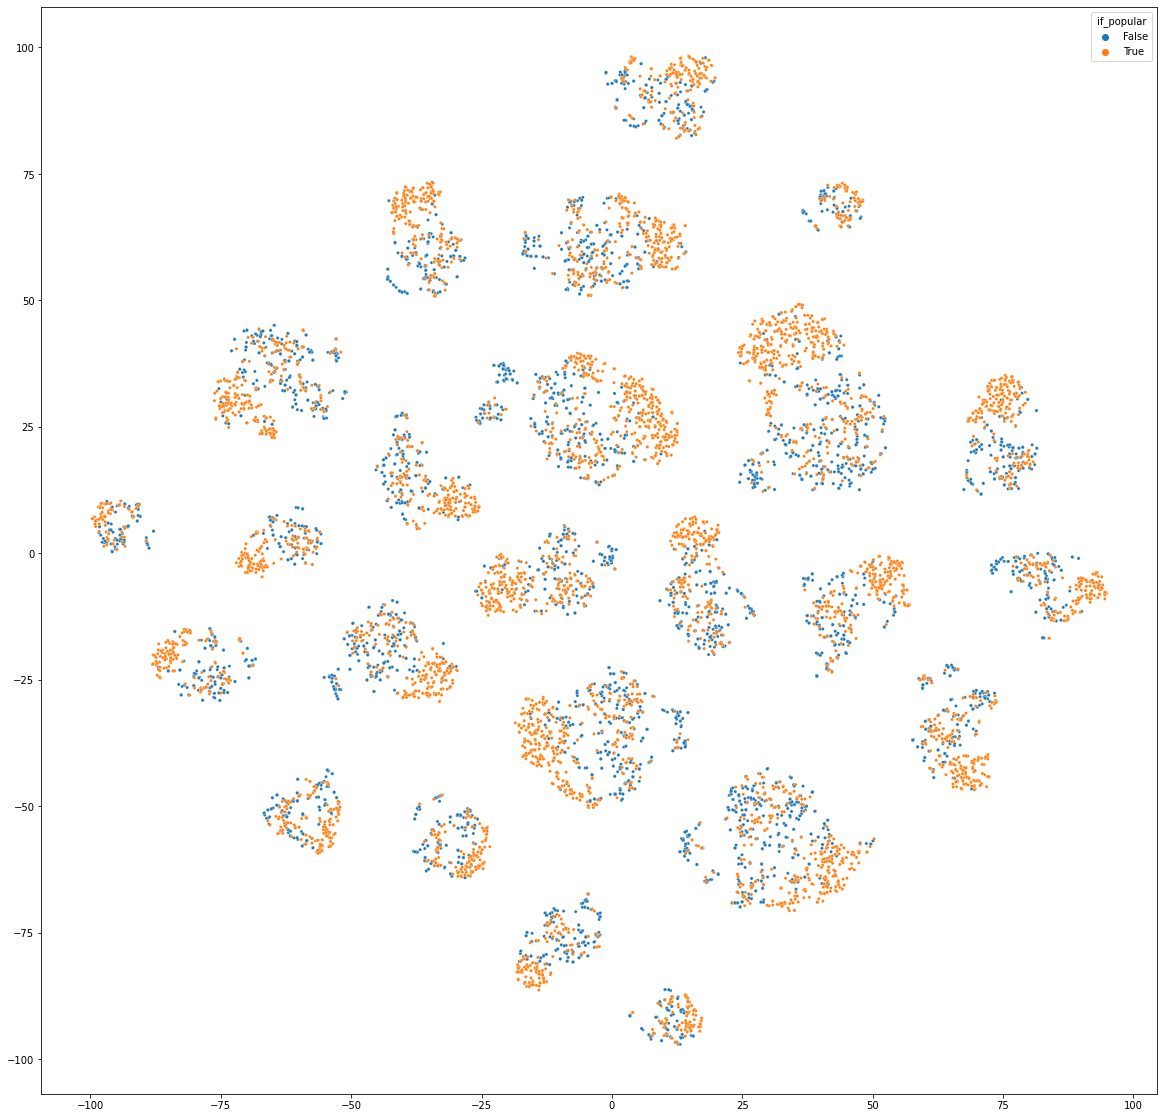

In [9]:
dimension(feature_all, y_popular, 'all_feature')

In [ ]:
#dbs_df = pd.DataFrame(columns = ['dbs', 'feature_extraction'])
#for row in result:
#    x = pd.Series(data=row, index=['dbs', 'feature_extraction'])
#    dbs_df = dbs_df.append(x, ignore_index=True)
#dbs_df

In [10]:
df_all_new = pd.read_csv("positive_and_negative_one_hot.csv")
fea_all_new = df_all_new[df_all_new.columns[7:19]]
fea_all_new

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,popularity
0,0.760040,0.806517,0.144170,0.529834,0.000373,0.359676,0.739733,1,0.049686,0.540682,0.570552,0.314607
1,0.020681,0.894094,0.141797,0.696247,0.000000,0.100000,0.789644,0,0.399371,0.693969,0.501022,0.000000
2,0.993976,0.554990,0.044422,0.088640,0.207661,0.113475,0.579224,1,0.039099,0.570105,0.640082,0.213483
3,0.214858,0.419552,0.169140,0.340364,0.000000,0.113475,0.682223,0,0.061635,0.639886,0.179959,0.011236
4,0.367469,0.695519,0.146753,0.631085,0.000000,0.142857,0.771183,0,0.299790,0.376136,0.712679,0.112360
...,...,...,...,...,...,...,...,...,...,...,...,...
9529,0.360441,0.821792,0.161581,0.773438,0.002188,0.306991,0.826203,0,0.291405,0.646297,0.886503,0.640449
9530,0.000092,0.542770,0.154411,0.932833,0.000793,0.100405,0.817852,1,0.076730,0.674827,0.553170,0.191011
9531,0.137549,0.719959,0.142190,0.833587,0.000000,0.116515,0.920379,1,0.054193,0.508760,0.805726,0.764045
9532,0.146585,0.626273,0.122640,0.520812,0.778226,0.111449,0.770324,1,0.033333,0.531659,0.046012,0.876404


dbs: 2.988350099878476


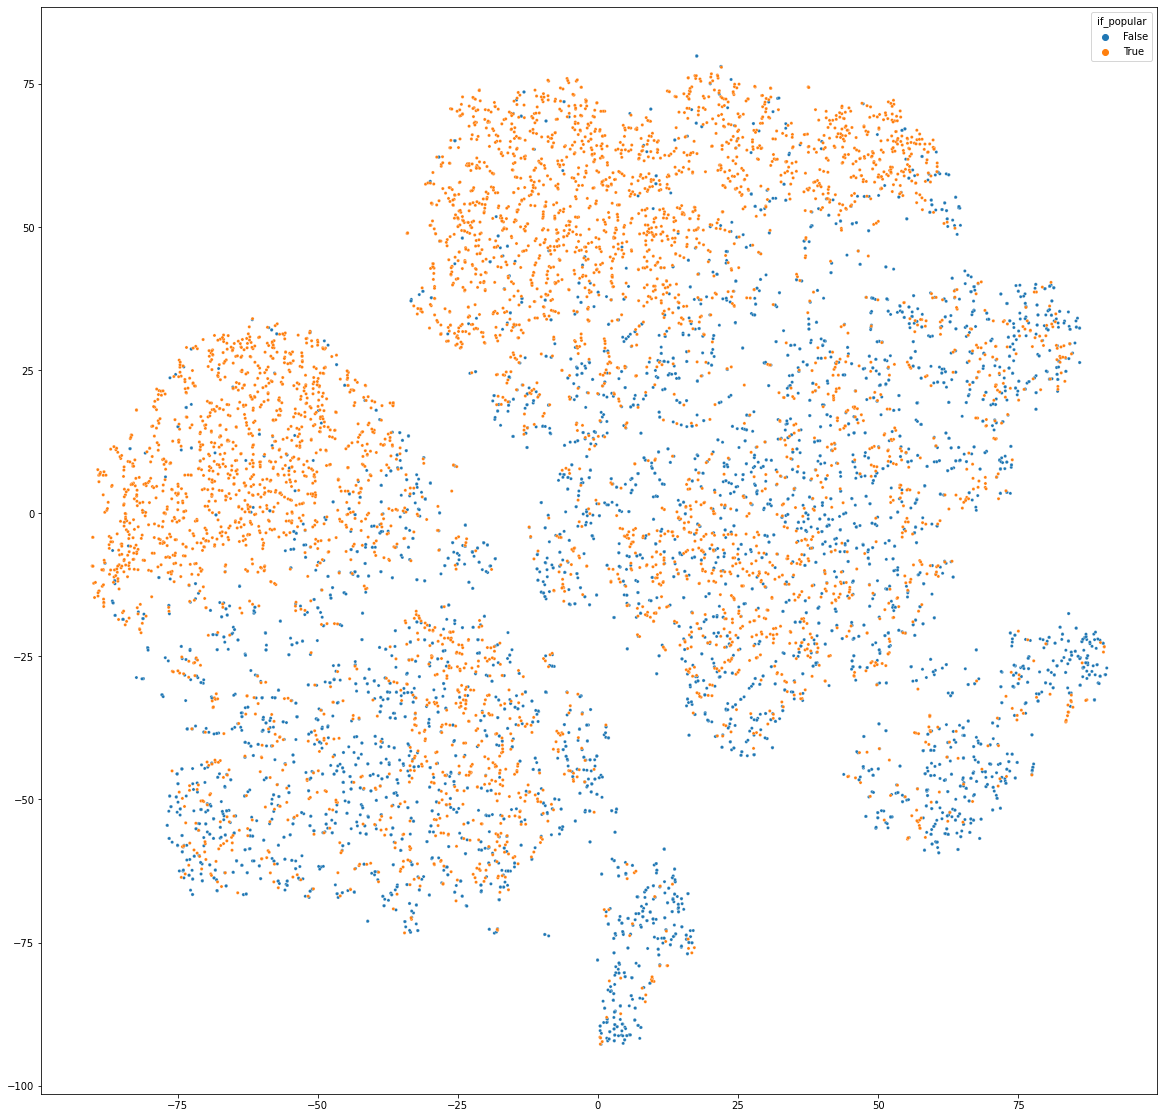

In [11]:
dimension(fea_all_new, y_popular, 'fea_one_hot')

## t-SNE on lyrics
### Obtain lyrics data

In [12]:
lyrics = df_all['lyrics'].tolist()

### Feature extraction

We have chosen some common feature extraction methods to use:

#### Term Frequency-Inverse Document Frequency (TF-IDF)
TF-IDF is a widely used feature extraction technique in natural language processing. It make use of the frequency of words to determine their relevance to a given document. 

It represents a document as a vector of weighted frequencies of words, with the weight of each words being proportional to its frequency in the document and inversely proportional to its frequency in the corpus.

In [13]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
x_tfidf = tfidf.fit_transform(lyrics)
type(x_tfidf)

scipy.sparse._csr.csr_matrix


#### Doc2Vec 
Doc2Vec is similar to Word2Vec. Both will not only generate vectors for different words, but also 'give meaning' to them in the vector space. Doc2vec is good at capturing both the semantic meeaning and the context of the entire documents, and it's widely used to perform classification. 

In [15]:
#doc2vec
corpus = [TaggedDocument(simple_preprocess(text), [i]) for i, text in enumerate(df_all['lyrics']) ]
model = GenSimDoc2Vec()
model.build_vocab(corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)
x_doc2vec = []
for doc_id in range(len(corpus)):
    doc_vec = model.infer_vector(corpus[doc_id].words)
    x_doc2vec.append(doc_vec)
x_doc2vec = pd.DataFrame(x_doc2vec)
type(x_doc2vec)


pandas.core.frame.DataFrame

#### Sentence-BERT (pre-trained by huggingface)
SBERT is a pre-trained deep learning model which uses a transformer-based architechture. It fine-tunes a pre-train Bidirectional Encoder Representations from Transformers (BERT) on various NLP tasks to produce high-quality sentence embeddings that capture the semantic meaning of the text. Here, we used sbert that's pre-trained by huggingface.

As it takes quite a longer time to compute sbert embedding of lyrics, it's saved in `sbert_lyrics.csv` to be reuse easily.

In [16]:
#model = SentenceTransformer("all-mpnet-base-v2")
#x_sbert = np.array(model.encode(a['lyrics'].to_list()))
x_sbert = pd.read_csv("sbert_lyrics.csv")
x_sbert 

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.046910,0.034324,0.026795,-0.044429,-0.011656,0.032259,-0.055147,0.023809,-0.010478,0.000033,...,-0.045766,-0.037377,0.002348,-0.023000,-0.020168,0.018647,-0.053356,-0.037901,0.001160,-0.021507
1,0.071048,-0.040200,0.004703,0.058830,0.022351,0.027987,-0.046437,-0.004486,-0.069335,0.006166,...,-0.041606,0.000521,-0.091821,0.014219,-0.039306,0.019359,0.008338,-0.004267,-0.066201,-0.056852
2,0.008718,0.008984,-0.033277,-0.023547,-0.018714,0.026739,0.063018,-0.089174,0.042993,0.020083,...,0.040838,0.017226,0.052838,0.015348,-0.010705,0.014663,0.003980,-0.009550,-0.004157,0.018592
3,-0.006864,0.004748,0.018412,-0.022092,-0.018444,0.041359,-0.042786,-0.057865,-0.040892,0.020674,...,-0.020621,-0.024661,0.056019,-0.010680,-0.072844,-0.010426,-0.039524,-0.060434,-0.007648,-0.009525
4,0.029358,0.013105,0.015589,-0.002989,-0.009379,0.056599,-0.068394,-0.026491,0.006526,0.026430,...,-0.021548,0.025352,0.023507,-0.018607,-0.025333,-0.027662,-0.036710,-0.015164,-0.064524,-0.002912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9529,0.034076,-0.073321,0.006680,-0.008928,-0.007415,0.008960,0.025881,-0.021879,0.049578,0.034439,...,-0.022876,0.032604,0.026805,-0.021827,-0.073643,0.023063,-0.001446,-0.020286,-0.029718,-0.080380
9530,0.021633,0.047251,-0.005513,-0.066926,-0.046665,0.008425,-0.013391,-0.026480,-0.047186,-0.005547,...,-0.006916,-0.009144,0.008757,0.032415,-0.025203,-0.026234,-0.066077,-0.055269,0.002091,-0.015663
9531,-0.042455,0.003679,-0.007404,0.023312,0.028252,0.028654,-0.009694,-0.016776,-0.010146,0.005827,...,-0.042593,-0.007873,-0.042376,-0.027900,-0.008383,0.084263,-0.002414,0.037885,-0.041416,-0.031960
9532,0.044347,-0.000056,-0.007047,0.026481,0.019490,-0.022959,0.004506,-0.005830,-0.012132,0.013844,...,-0.007913,0.013574,0.002217,0.041223,0.004692,0.034444,-0.000611,-0.004954,-0.021672,-0.003690


### t-SNE on different vector representation of lyrics

dbs: 5.174180432378238


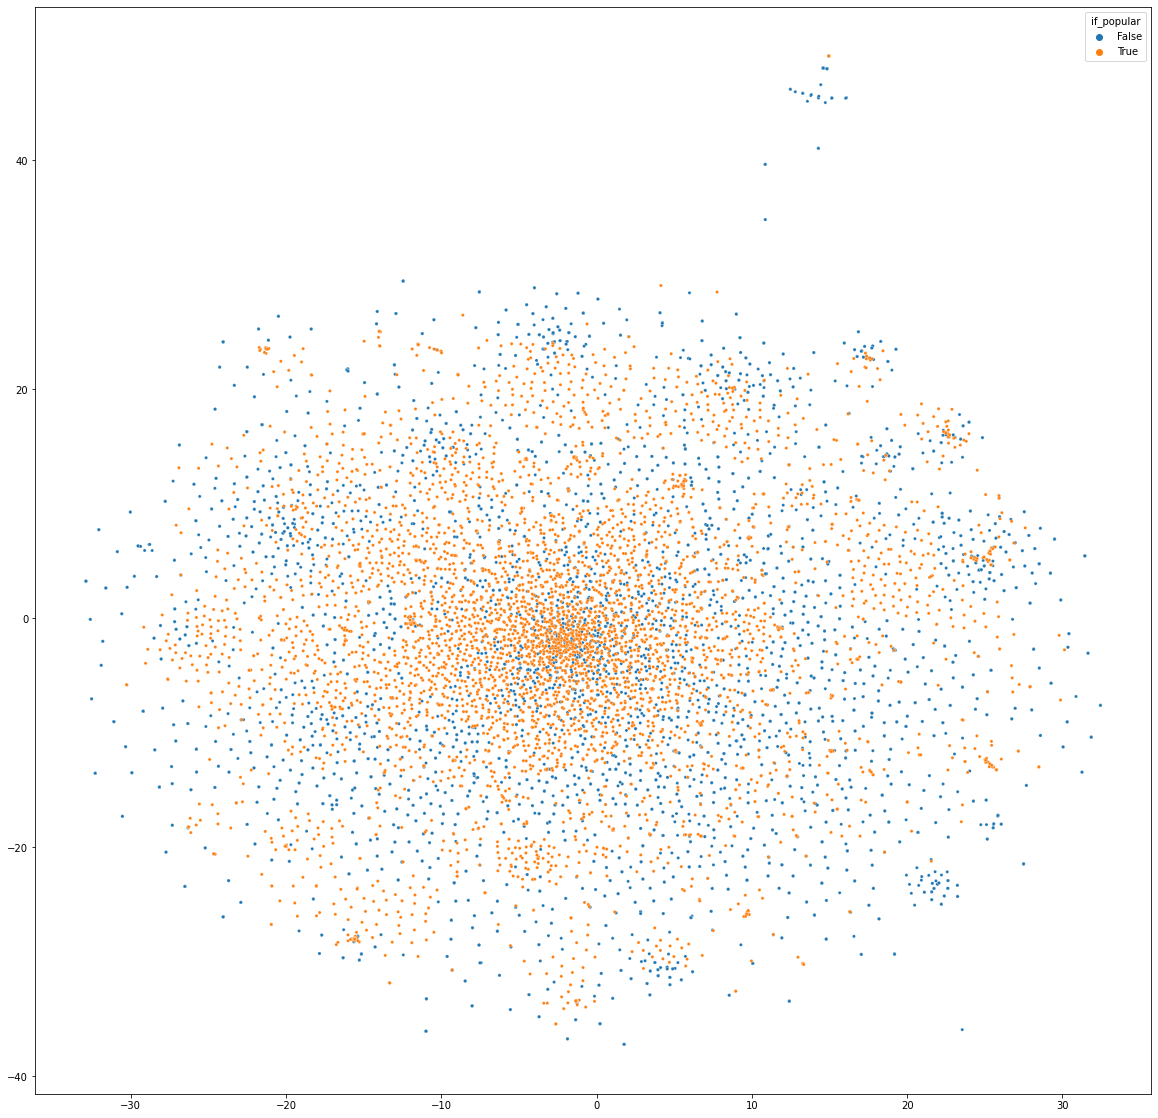

In [17]:
dimension(x_tfidf, y_popular, 'tfidf')

dbs: 5.357305178069556


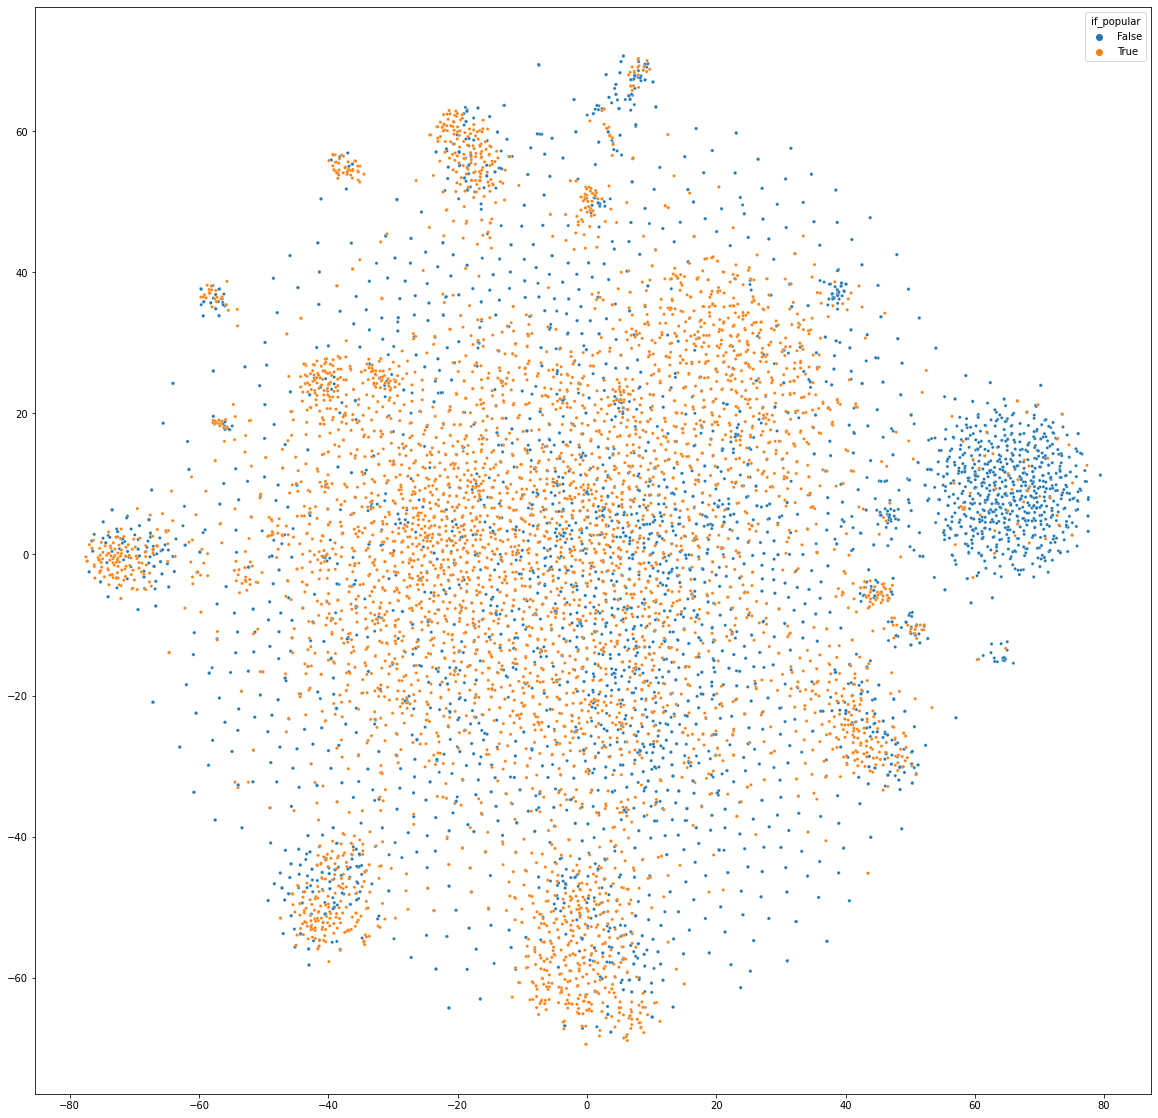

In [18]:
dimension(x_doc2vec, y_popular, 'doc2vec')

dbs: 5.811652594575833


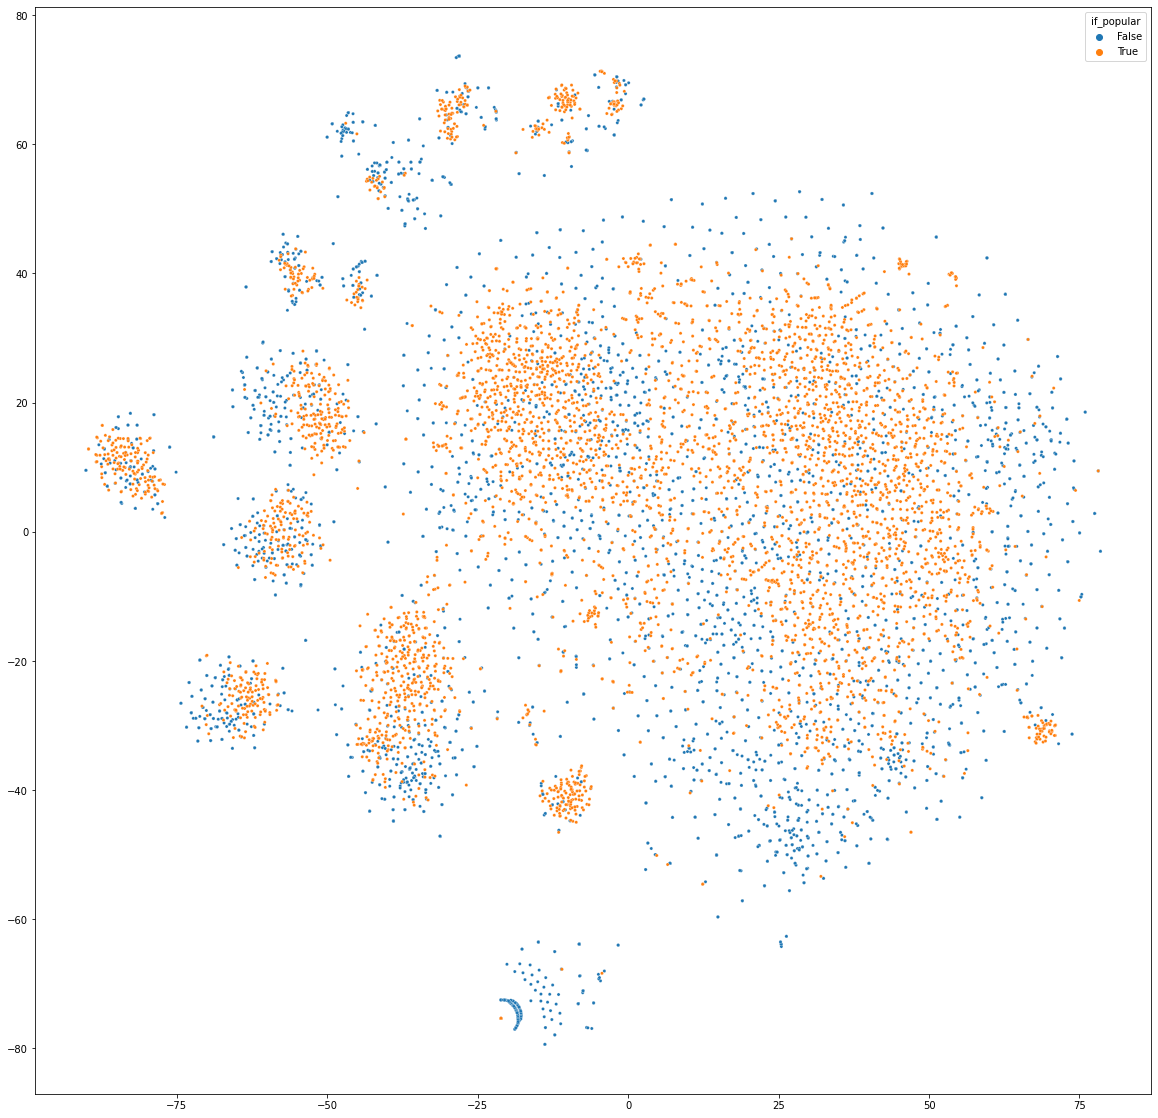

In [19]:
dimension(x_sbert, y_popular, 'sbert')

The DBS of lyrics representation produced by all 3 feature extraction method is around 5 to 6. 

However, we are not satisfy with the result and decided to train our own BERT

## insight!!!! we train our own bert

In [90]:
df_bert = pd.read_csv("hiddenLayer.csv")
df_bert

,hidden,class
0,[[-0.5549818 -0.7334654 -0.5830097 -0.65206...,0.0
1,[[ 1.4992108 -0.7334654 0.51447606 1.30794...,0.0
2,[[-0.5549818 -0.45736355 -0.5830097 -0.65206...,1.0
3,[[ 0.80020654 -0.7334654 1.436557 -0.32266...,0.0
4,[[-0.5549818 -0.7334654 -0.5830097 -0.65206...,1.0
...,...,...
1902,[[-0.5549818 -0.1957471 -0.5830097 -0.65206...,1.0
1903,[[-0.5549818 -0.7334654 -0.5830097 -0.65206...,1.0
1904,[[-0.5549818 1.0180724 -0.22937158 1.04352...,0.0
1905,[[ 0.5880587 -0.7334654 -0.5830097 0.16415...,0.0


In [91]:
type(df_bert['hidden'][0])

str

In [92]:
df_bert['hidden'] = df_bert['hidden'].apply(lambda x: list(filter(lambda a: a != '', x[2:-2].replace('\n', '').split(' '))))
df_bert['hidden'] = df_bert['hidden'].apply(lambda x: [float(t) for t in x])
df_bert

,hidden,class
0,"[-0.5549818, -0.7334654, -0.5830097, -0.652067...",0.0
1,"[1.4992108, -0.7334654, 0.51447606, 1.3079475,...",0.0
2,"[-0.5549818, -0.45736355, -0.5830097, -0.65206...",1.0
3,"[0.80020654, -0.7334654, 1.436557, -0.32266042...",0.0
4,"[-0.5549818, -0.7334654, -0.5830097, -0.652067...",1.0
...,...,...
1902,"[-0.5549818, -0.1957471, -0.5830097, -0.652067...",1.0
1903,"[-0.5549818, -0.7334654, -0.5830097, -0.652067...",1.0
1904,"[-0.5549818, 1.0180724, -0.22937158, 1.0435251...",0.0
1905,"[0.5880587, -0.7334654, -0.5830097, 0.1641501,...",0.0


In [93]:
type(df_bert['hidden'])

pandas.core.series.Series

In [95]:
x_bert = pd.DataFrame(dict(zip(df_bert['hidden'].index, df_bert['hidden'].values))).T
x_bert


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.554982,-0.733465,-0.583010,-0.652068,1.373516,0.934801,0.311391,-0.754227,-0.682836,-0.643049,...,0.984671,-0.749289,-0.587978,0.224244,-0.730679,-0.713030,-0.723907,1.174061,-0.627248,1.209486
1,1.499211,-0.733465,0.514476,1.307948,-0.498709,0.326324,-0.638949,1.166858,0.532067,1.667784,...,-0.878862,2.070535,1.742663,-0.649187,-0.022959,0.649242,1.083975,-0.875449,0.400812,-0.783748
2,-0.554982,-0.457364,-0.583010,-0.652068,-0.058005,-0.091907,1.395333,-0.754227,-0.714112,-0.156873,...,0.394395,-0.749289,-0.587978,1.312043,-0.700836,-0.713030,-0.723907,0.952373,-0.627248,1.088684
3,0.800207,-0.733465,1.436557,-0.322660,-0.602575,-0.524481,-0.638949,-0.066252,0.720454,0.666940,...,-0.413619,0.779096,0.442526,-0.649187,0.228001,1.264313,-0.044653,-0.654141,-0.469930,-0.783748
4,-0.554982,-0.733465,-0.583010,-0.652068,0.040503,-0.524481,-0.638949,-0.285446,-0.119312,0.122920,...,0.041149,-0.749289,-0.587978,0.210079,0.062983,-0.713030,-0.723907,0.880558,-0.553643,-0.309313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902,-0.554982,-0.195747,-0.583010,-0.652068,-0.704860,-0.524481,3.359408,-0.754227,-0.714112,0.343174,...,1.048473,-0.749289,-0.587978,1.028055,0.181509,-0.713030,-0.723907,0.755878,0.704645,0.614796
1903,-0.554982,-0.733465,-0.583010,-0.652068,0.936140,-0.524481,0.835380,-0.754227,-0.556288,-0.151066,...,0.860878,-0.749289,-0.587978,0.855064,-0.730679,-0.713030,-0.723907,1.529323,-0.016247,1.383716
1904,-0.554982,1.018072,-0.229372,1.043525,-0.704860,0.348657,-0.363162,1.800995,0.804710,-0.643049,...,-0.878862,1.321189,0.745506,-0.649187,-0.730679,1.276584,1.964027,-0.875449,0.041128,-0.783748
1905,0.588059,-0.733465,-0.583010,0.164150,-0.061058,0.420137,-0.638949,0.731154,-0.257903,0.885454,...,-0.558147,1.511596,1.935226,-0.649187,0.499966,1.067513,0.844723,-0.875449,0.505586,-0.783748


dbs: 1.359739433882817


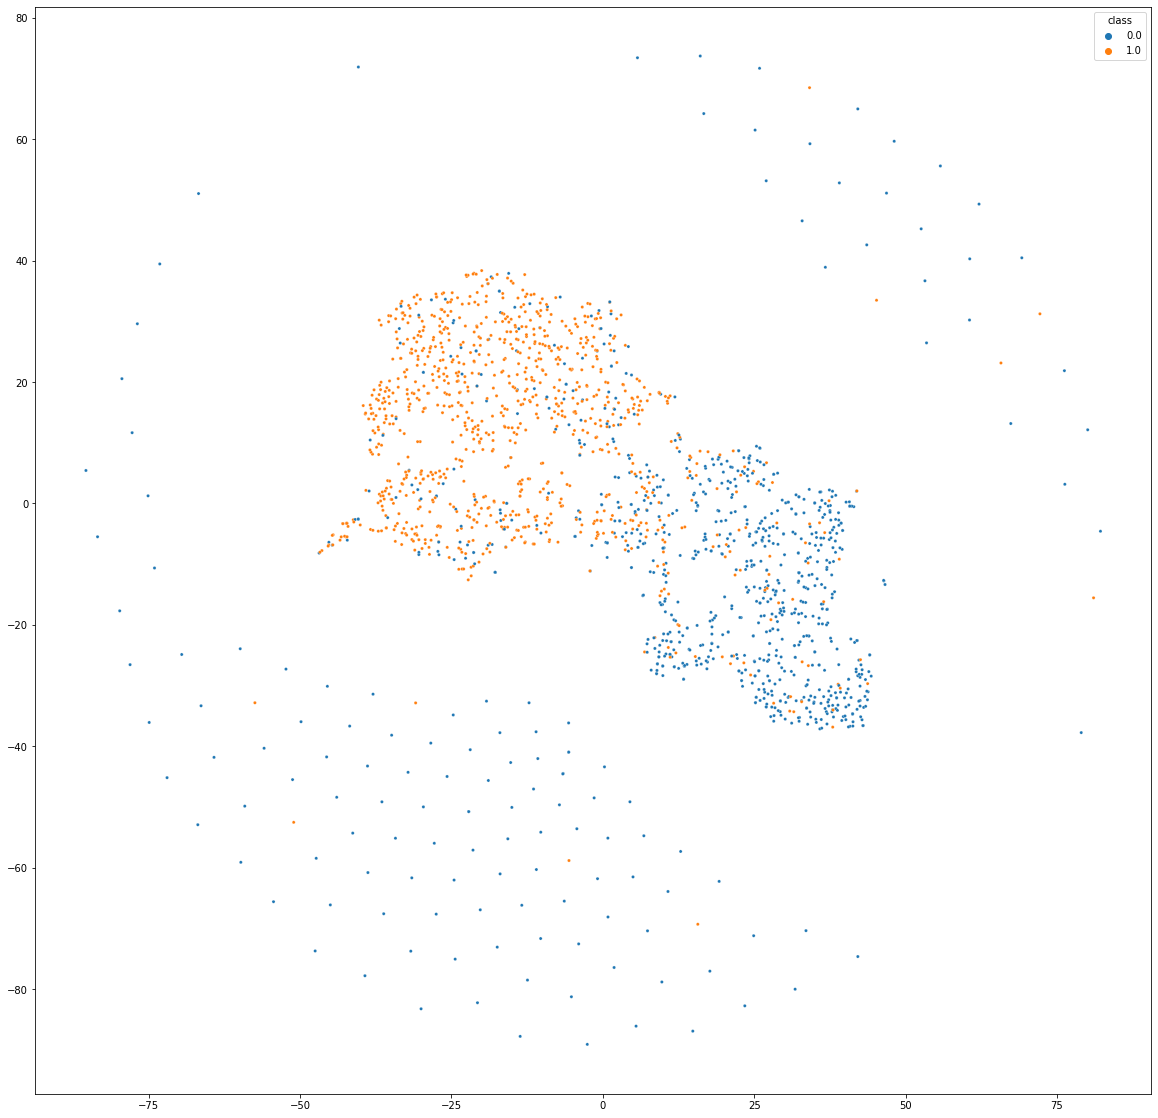

In [96]:
dimension(x_bert, df_bert['class'], 'self_bert')